# Pytorch-预训练VGG中间层可解释性分析

使用shap库的`GradientExplainer`，对预训练VGG16模型的中间层输出，计算shap值。

## 导入工具包

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch, torchvision
from torch import nn
from torchvision import transforms, datasets
import shap
import json
import numpy as np
from COME15KClassDataset import set_data_loader
from PIL import Image

In [2]:
# 数据集文件夹路径
dataset_name = 'test_easy_classes'
# dataset_name = 'test_hard_classes'
model_path = './models/2023-10-09-01-47_max_epoch_100/'
model_name = 'retrain_COME15K_checkpoint-best-avg-0.743-Medium.pth.tar'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

# 类别名称 和 ID索引号 的映射字典
class_names_dic = {0: 'covering', 1: 'device', 2: 'domestic_animal', 3: 'mater', 4: 'person', 5: 'plant',
                       6: 'structure', 7: 'vertebrate'}
# 获得类别名称
class_names = list(class_names_dic.values())
print(class_names)

device cuda:0
['covering', 'device', 'domestic_animal', 'mater', 'person', 'plant', 'structure', 'vertebrate']


## 载入模型

In [3]:
# init model
model_and_weight_path = model_path + model_name
model = torch.load(model_and_weight_path)
model = model.eval().to(device)
model

ShuffleNetV2_Plus(
  (first_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
    (2): HS()
  )
  (features): Sequential(
    (0): Shufflenet(
      (branch_main): Sequential(
        (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (5): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
      )
     

## 载入数据集，预处理

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float().to(device)

## 指定测试图像

In [5]:
test_dataset_loader_easy = set_data_loader(dataset_attr_word="test_easy", batch_size=1, size=512, shuffle=False,
                                           transforms_compose=None, dataset_dir = 'data/SOD-SemanticDataset-OriginalSize')
data_path = test_dataset_loader_easy.dataset.data_path
img_paths = test_dataset_loader_easy.dataset.images
img_lables = test_dataset_loader_easy.dataset.labels

In [6]:
img_paths_final = [data_path + img_name for img_name in img_paths]
img_np_list = []
for img_path in img_paths_final[0:50]:
    img = Image.open(img_path).convert('RGB')
    img_pil = img.resize((224, 224)) 
    img_pil = np.asarray(img_pil)
    img_pil = img_pil / 255  #归一化
    img_np_list.append(img_pil.tolist())

In [7]:
img_list = np.array(img_np_list)
print(img_list.shape)

(50, 224, 224, 3)


In [8]:
to_explain = img_list[[10, 13]]
print(to_explain.shape)

(2, 224, 224, 3)


## 载入类别和索引号

In [9]:
class_names_dic = {0: 'covering', 1: 'device', 2: 'domestic_animal', 3: 'mater', 4: 'person', 5: 'plant',
                       6: 'structure', 7: 'vertebrate'}

## 计算模型中间层，在输入图像上的shap值

In [10]:
# 指定中间层
layer_index = 19

# 迭代次数，200次大约需计算 5 分钟
samples = 200

In [11]:
e = shap.GradientExplainer((model, model.features[layer_index]), normalize(img_list))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=8, nsamples=samples)

## 预测类别名称

In [12]:
indexes = indexes.cpu().numpy()
print(indexes)
index_names = np.vectorize(lambda x: class_names_dic[x])(indexes)

[[0 4 6 3 5 7 2 1]
 [4 0 3 6 5 1 7 2]]


In [13]:
index_names

array([['covering', 'person', 'structure', 'mater', 'plant',
        'vertebrate', 'domestic_animal', 'device'],
       ['person', 'covering', 'mater', 'structure', 'plant', 'device',
        'vertebrate', 'domestic_animal']], dtype='<U15')

## 可视化

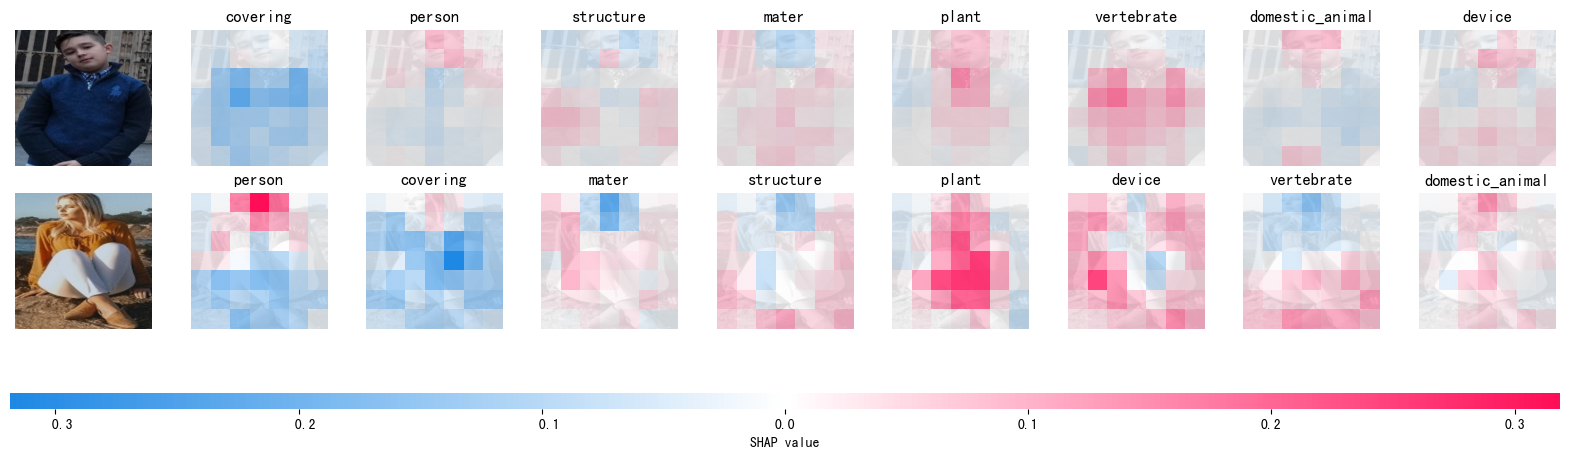

In [14]:
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## 在图像上引入局部平滑

Gradient explainer的期望梯度，融合了integrated gradients, SHAP, SmoothGrad的思想，只需将`local_smoothing`参数设置为非0即可。在计算期望时，在输入图像加入正态分布噪声，绘制出更平滑的显著性分析图。

In [18]:
# 计算模型中间层，在输入图像上的shap值
explainer = shap.GradientExplainer((model, model.features[layer_index]), normalize(img_list), local_smoothing=0.5)
shap_values, indexes = explainer.shap_values(normalize(to_explain), ranked_outputs=8ShufflenetShufflenetShufflenetShufflenet, nsamples=samples)

In [19]:
# 预测类别名称
indexes = indexes.cpu().numpy()
print(indexes)
index_names = np.vectorize(lambda x: class_names_dic[x])(indexes)
index_names

[[0 4 6 3 5 7 2 1]
 [4 0 3 6 5 1 7 2]]


array([['covering', 'person', 'structure', 'mater', 'plant',
        'vertebrate', 'domestic_animal', 'device'],
       ['person', 'covering', 'mater', 'structure', 'plant', 'device',
        'vertebrate', 'domestic_animal']], dtype='<U15')

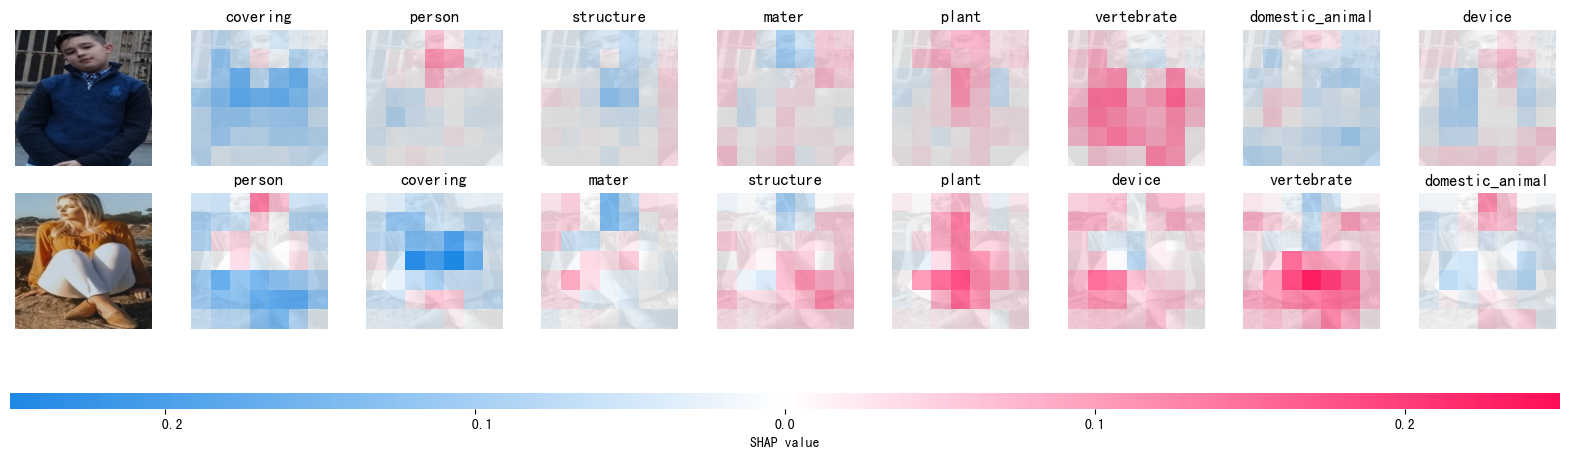

In [20]:
# 可视化
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

可以看出，模型浅层输出的显著性分析图，虽然具有细粒度、高分辨率，但不具有类别判别性（class discriminative）。

模型深层输出的显著性分析图，虽然分辨率较低，但具有类别判别性。